### STDOUT.0000

In [10]:
import re
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import subprocess

def mitgcm_history(file, *keywords):

    """
    Extracts diagnostic time series data from a MITgcm standard output history file.

    Parameters
    ----------
    file : str
        Path to the MITgcm standard output (.stdout) file.
    *keywords : str
        One or more diagnostic field names (e.g., 'KE', 'PE') to extract.

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (timesteps, diagnostics), where each column
        corresponds to the time series of one requested diagnostic.

    Notes
    -----
    - Uses `grep` and `sed` to extract matching lines and parse floating-point values.
    - Non-parsable or missing values are replaced with 0.0 or a fallback value.
    - All output columns are truncated to the same minimum length to allow stacking.
    - Handles corrupted or malformed numeric strings gracefully.
    - Issues a warning if a keyword is not found or contains no valid numbers.
    """
    
    if len(keywords) == 0:
        raise ValueError("You must supply at least one diagnostic keyword to search for.")

    data = []
    min_len = None

    for kw in keywords:
        # Use grep and sed via subprocess
        cmd = f"grep '{kw}' '{file}' | sed 's/.*=//' | sed 's/NAN/1.23456789/'"
        try:
            result = subprocess.check_output(cmd, shell=True, text=True)
        except subprocess.CalledProcessError:
            print(f"Warning: No entries found for '{kw}'")
            result = ""

        # Parse values line by line
        vals = []
        for line in result.strip().split('\n'):
            line = line.strip()
            try:
                # Sometimes corrupted numbers like "-3.2e-321-123" appear
                matches = re.findall(r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?", line)
                if matches:
                    vals.append(float(matches[0]))
                else:
                    vals.append(0.0)  # fallback for non-parseable values
            except Exception:
                vals.append(0.0)

        if not vals:
            print(f"Warning: No valid numbers found for '{kw}'")
            vals = [np.nan]

        if min_len is None:
            min_len = len(vals)
        else:
            min_len = min(min_len, len(vals))

        data.append(vals[:min_len])

    # Make sure all columns are trimmed to same length
    trimmed = [np.array(col[:min_len]) for col in data]
    return np.stack(trimmed, axis=1)

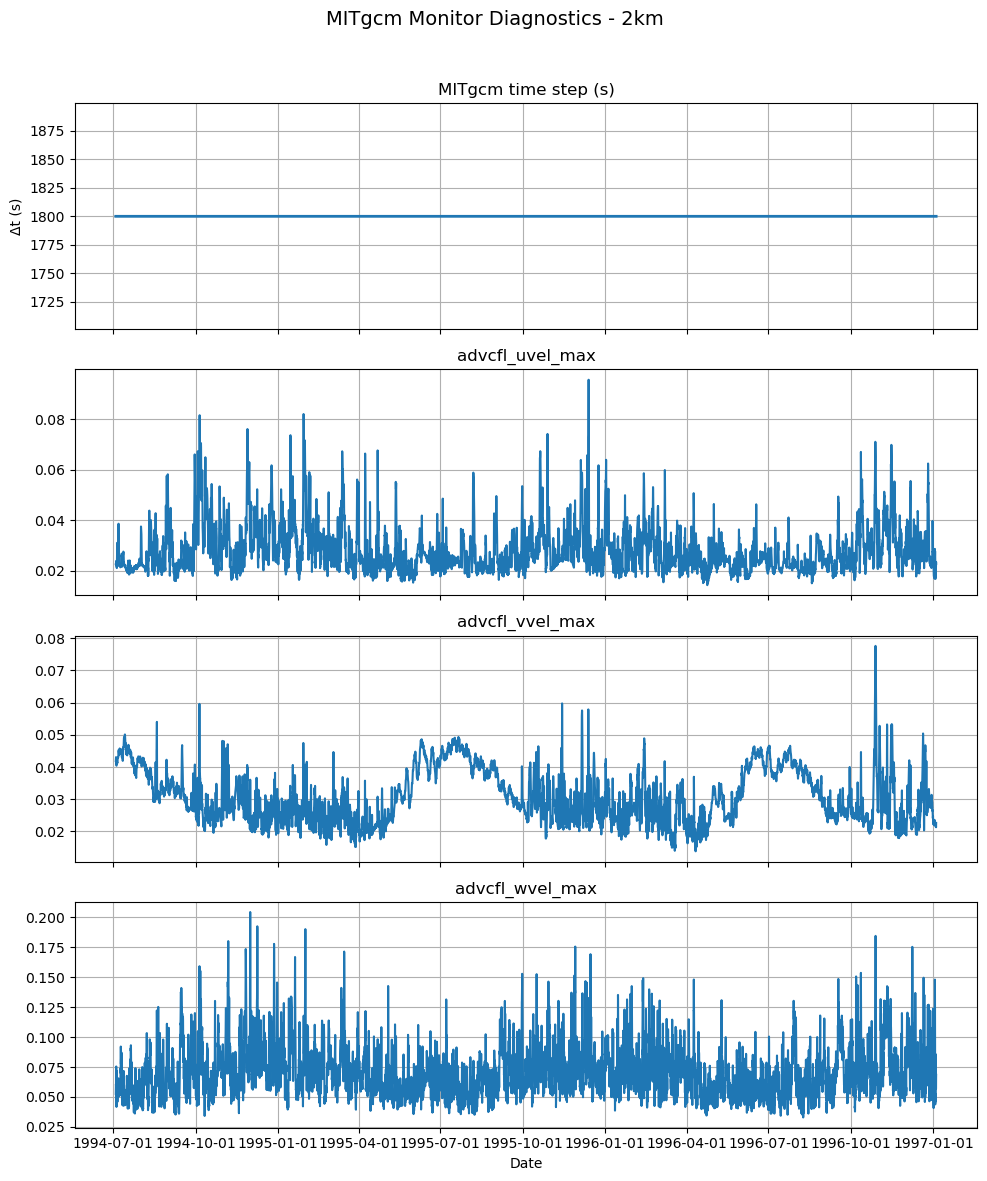

In [11]:
### To look at a single file ###

# Parameters
file_path = "/home/hinne/Downloads/data_ToTs/STDOUT/STDOUT_notides_5yr" # path to the MITgcm STDOUT.0000 file
deltat = 1800  # time step in seconds
start_date = datetime.datetime(1992, 1, 1) # start date for the time series

# Always extract time first
time_vals = mitgcm_history(file_path, 'time_secondsf')[:, 0]

# Then for other diagnostics
diagnostics_vars = ['advcfl_uvel_max', 'advcfl_vvel_max', 'advcfl_wvel_max'] #put whatever variables you want here. Should be from monitor in STDOUT
data_vars=[]
for kw in diagnostics_vars:
    var_vals = mitgcm_history(file_path, kw)[:, 0]
    var_vals = var_vals[:len(time_vals)]  # match length to time
    data_vars.append(var_vals)

# Trim time if needed (in case any diagnostic is shorter)
min_len = min([len(time_vals)] + [len(d) for d in data_vars])
time_vals = time_vals[:min_len]
data_vars = [d[:min_len] for d in data_vars]

# Convert time to datetime
TME = np.array([start_date + datetime.timedelta(seconds=s) for s in time_vals])

# Other variables
DT = np.full_like(time_vals, fill_value=deltat)
var1, var2, var3= data_vars

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.subplots_adjust(hspace=0.3)

axs[0].plot(TME, DT, linewidth=2)
axs[0].set_title("MITgcm time step (s)")
axs[0].set_ylabel("Δt (s)")
axs[0].grid()

axs[1].plot(TME, var1)
axs[1].set_title(diagnostics_vars[0])
axs[1].grid()

axs[2].plot(TME, var2)
axs[2].set_title(diagnostics_vars[1])
axs[2].grid()

axs[3].plot(TME, var3)
axs[3].set_title(diagnostics_vars[2])
axs[3].set_xlabel("Date")
axs[3].grid()

# Format date axis
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.suptitle("MITgcm Monitor Diagnostics - 2km", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("monitor_2km.png", dpi=300)
plt.show()



In [5]:
import datetime
import numpy as np

### This function extracts a full set of MITgcm diagnostics from a STDOUT file. ###

def extract_all_mitgcm_diagnostics(file_path, start_date=datetime.datetime(1992, 1, 1), deltat=1800):
    """
    Extract a full set of diagnostics from a MITgcm STDOUT file.

    Returns:
        TME (np.array): Array of datetime timestamps
        DT (np.array): Array of time step values
        data_vars (dict): Dictionary of {diagnostic_name: np.array}
    """

    # Define diagnostic variable groups
    dynstat = ['eta', 'uvel', 'vvel', 'wvel', 'theta', 'salt', 'sst', 'sss']
    forcing = ['qnet', 'qsw', 'empmr', 'fu', 'fv']
    trAdv = ['u', 'v', 'w']
    advcfl = ['uvel', 'vvel', 'wvel', 'W_hf']
    vort = ['r_min', 'r_max', 'a_mean', 'a_sd', 'p_mean', 'p_sd']
    surfExpan = ['theta_mean', 'salt_mean']
    seaice = ['uice', 'vice', 'area', 'heff', 'hsnow']

    # Start with time
    fld = ['time_tsnumber', 'time_secondsf']

    # Add diagnostics with suffixes
    for group, prefix in [(dynstat, 'dynstat'), (forcing, 'forcing'), (seaice, 'seaice')]:
        for var in group:
            for suf in ['max', 'min', 'mean', 'sd', 'del2']:
                fld.append(f"{prefix}_{var}_{suf}")

    # Add CFL and energy/vorticity/expansion
    for var in trAdv:
        fld.append(f"trAdv_CFL_{var}_max")
    for var in advcfl:
        fld.append(f"advcfl_{var}_max")
    fld += ['pe_b_mean', 'ke_max', 'ke_mean', 'ke_vol']
    for var in vort:
        fld.append(f"vort_{var}")
    for var in surfExpan:
        fld.append(f"surfExpan_{var}")

    # Extract values
    data_vars = {}
    min_len = None

    for kw in fld:
        vals = mitgcm_history(file_path, kw)[:, 0]
        if min_len is None:
            min_len = len(vals)
        else:
            min_len = min(min_len, len(vals))
        data_vars[kw] = vals

    # Trim all to same length
    for key in data_vars:
        data_vars[key] = data_vars[key][:min_len]

    # Build time arrays
    time_vals = data_vars['time_secondsf']
    TME = np.array([start_date + datetime.timedelta(seconds=s) for s in time_vals])
    DT = np.full_like(time_vals, fill_value=deltat)

    return TME, DT, data_vars


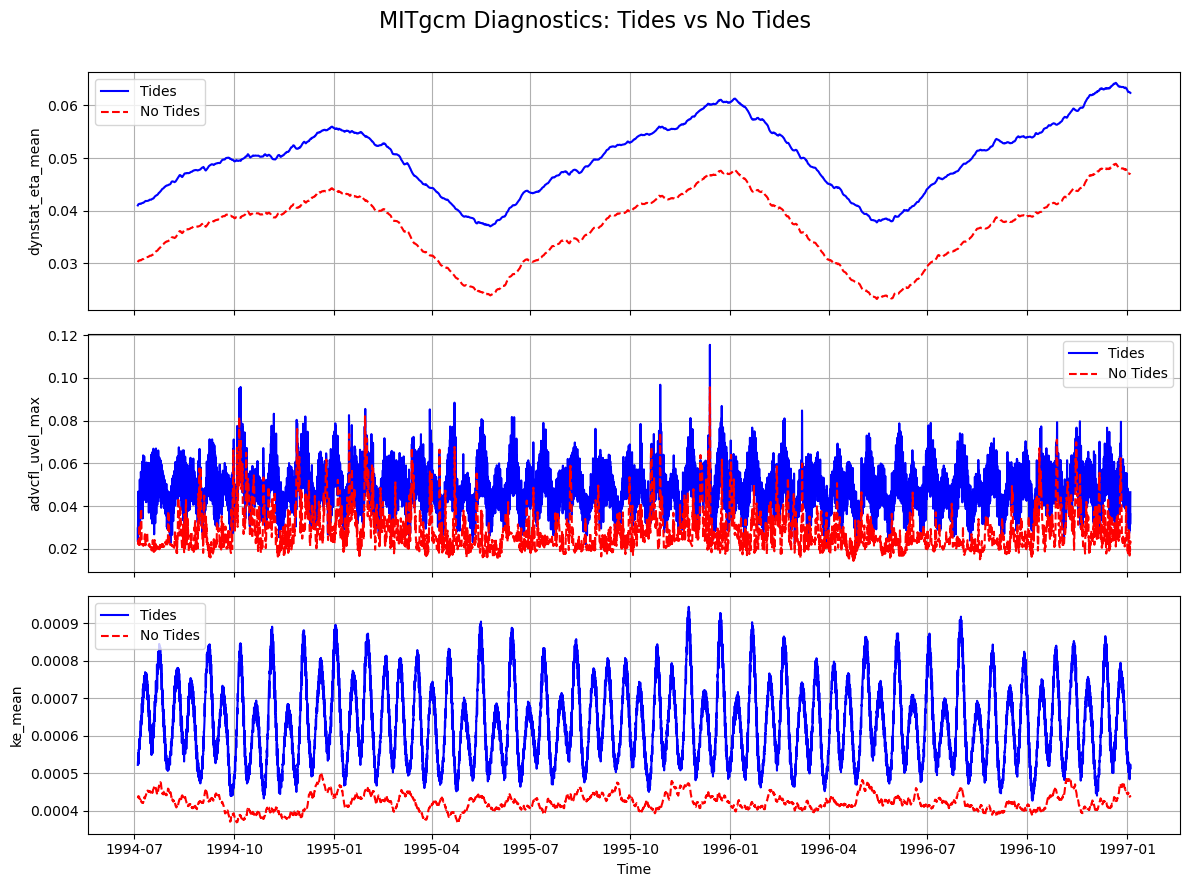

In [8]:
### To compare two output files ###

file_path_tides = "/home/hinne/Downloads/data_ToTs/STDOUT/STDOUT_tides_5yr"
file_path_notides = "/home/hinne/Downloads/data_ToTs/STDOUT/STDOUT_notides_5yr"

TME_tides, DT_tides, data_tides = extract_all_mitgcm_diagnostics(file_path_tides)
TME_notides, DT_notides, data_notides = extract_all_mitgcm_diagnostics(file_path_notides)

vars_to_plot = ['dynstat_eta_mean', 'advcfl_uvel_max', 'ke_mean']

fig, axs = plt.subplots(len(vars_to_plot), 1, figsize=(12, 3 * len(vars_to_plot)), sharex=True)

for i, var in enumerate(vars_to_plot):
    axs[i].plot(TME_tides, data_tides[var], label='Tides', color='blue')
    axs[i].plot(TME_notides, data_notides[var], label='No Tides', color='red', linestyle='--')
    axs[i].set_ylabel(var)
    axs[i].legend()
    axs[i].grid()

axs[-1].set_xlabel("Time")
fig.suptitle("MITgcm Diagnostics: Tides vs No Tides", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
### plot all variables from two datasets and save to output directory ###

def plot_all_variables(data_tides, data_notides, TME_tides, TME_notides, output_dir=None):
    # Get common keys, excluding time
    variable_keys = sorted(set(data_tides.keys()) & set(data_notides.keys()) - {'time_secondsf', 'time_tsnumber'})

    for key in variable_keys:
        vals_tides = data_tides[key]
        vals_notides = data_notides[key]

        # Ensure same length for plotting
        min_len = min(len(vals_tides), len(vals_notides), len(TME_tides), len(TME_notides))
        t_tides = TME_tides[:min_len]
        t_notides = TME_notides[:min_len]
        vals_tides = vals_tides[:min_len]
        vals_notides = vals_notides[:min_len]

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(t_tides, vals_tides, label='Tides', color='blue')
        plt.plot(t_notides, vals_notides, label='No Tides', color='red', linestyle='--')
        plt.title(f'{key}')
        plt.xlabel("Time")
        plt.ylabel(key)
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(f"{output_dir}/{key}.png", dpi=150)
            plt.close()
        else:
            plt.show()


#plot_all_variables(data_tides, data_notides, TME_tides, TME_notides, output_dir="figs_tides_notides")
